### Convolutional Neural Network

##### Convolutional Neural Network Example Flowchart

上一节中的 Linear Model，我们在 MNIST 数据集上得到 91.7% 的结果；而使用 CNN，可以得到接近 99% 的成绩！ CNN 的 Flowchar 如下

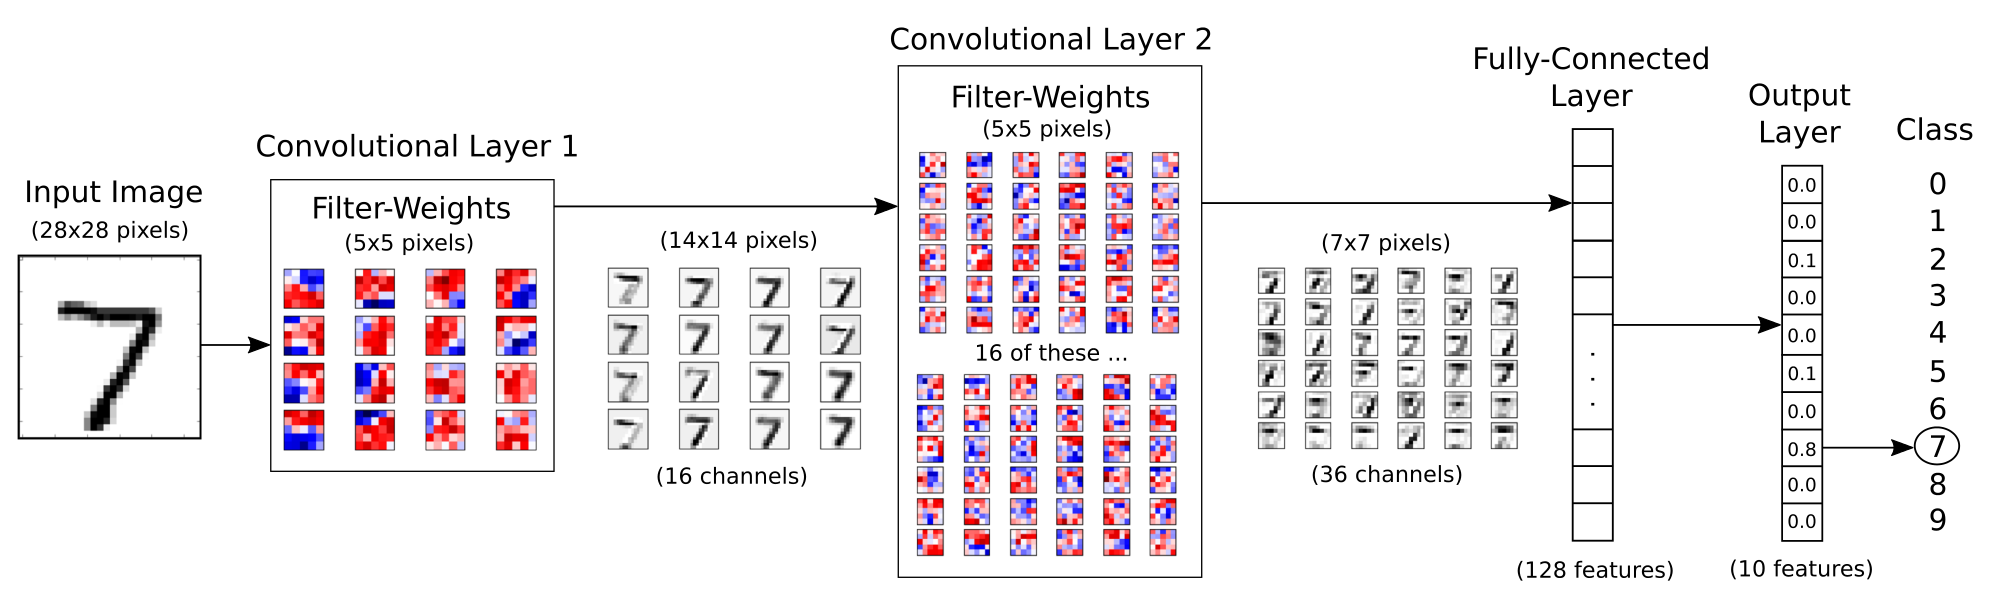

In [3]:
from IPython.display import Image
Image('images/02_network_flowchart.png')

1. 图中是一个 input image 的情况，而实际上，我们 feed in 的是一个 mini batch 的 images，后面假设 mini batch 中图片的个数为 N

2. 图片本身其实有一个 channel 的概念，对于 CNN 的输入层 input images 来说，通常是指图片像素在红绿蓝(RGB) 3 个颜色上各自的数值，于是 3 个 channels 上各自形成一个"子图片"，3 个子图片合在一起才是原始图片；不过这里由于是灰度图片，故此只有一个 channel；这里要弄清晰的是，一个图片，是指其全部 channels 的子图片的集合，子图片并不限于一张

3. channel 的概念，在 CNN 的 convolutional 层 (隐藏层中的一种) 被推广，不再限于 RGB 的概念，而是定义为一个 filter 对原图片 (注意这个原图片本身也是由各 channels 子图片合成的) 进行卷积后得到的新图片；就是说，一个原图片，经过多少个 filters 卷积，就得到多少个 channels 的输出图片

4. 图中所有的 filters 都是 5 * 5，同时采用 "SAME" 的方式进行卷积。这种方式在图片边缘会采用 padding 的方法，故此卷积之后得到的新图片会和原图片有相同的尺寸；每个 Convolutional 层都带一个 Pooling，把卷积的结果图片 downsampling 为 1/4 大小的最终结果

好了，基础打完了，看一下流程，才能对上面所说的有更清楚的理解

Convolutional Layer 1. 
- 输入 N 个 28 * 28 的图片，每个图片都只有一个 channel
- Layer 属性：输入图片的 channel 数，这里是 1；filter 的尺寸 5 * 5；filter 个数 (也就是说输出结果图片的 channel 个数) 16
- 输出：N 个 14 * 14 的图片 (经过了 Pooling)，每个图片 16 个 channels

16 个 filters，每个 filters 通过卷积去抽取原图片某一方面的特征，得到 28 * 28 的对应特征图；再通过 Pooling 被 downsampling 为 14 * 14 的特征图；16 个 filters 得到 16 套特征；这 16 套特征都是原图片的特征，都对应一个原图片，故此，最后得到的仍然是 N 个图片，只不过每个图片都有 16 套特征，对应 16 个 channels (子图片)

These 16 smaller images are then processed in the second convolutional layer. We need filter-weights for each of these 16 channels, and we need filter-weights for each output channel of this layer. There are 36 output channels so there are a total of 16 x 36 = 576 filters in the second convolutional layer. The resulting images are down-sampled again to 7x7 pixels.
The output of the second convolutional layer is 36 images of 7x7 pixels each. These are then flattened to a single vector of length 7 x 7 x 36 = 1764, which is used as the input to a fully-connected layer with 128 neurons (or elements). This feeds into another fully-connected layer with 10 neurons, one for each of the classes, which is used to determine the class of the image, that is, which number is depicted in the image.
The convolutional filters are initially chosen at random, so the classification is done randomly. The error between the predicted and true class of the input image is measured as the so-called cross-entropy. The optimizer then automatically propagates this error back through the Convolutional Network using the chain-rule of differentiation and updates the filter-weights so as to improve the classification error. This is done iteratively thousands of times until the classification error is sufficiently low.
These particular filter-weights and intermediate images are the results of one optimization run and may look different if you re-run this Notebook.
Note that the computation in TensorFlow is actually done on a batch of images instead of a single image, which makes the computation more efficient. This means the flowchart actually has one more data-dimension when implemented in TensorFlow.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
tf.__version__

'0.8.0'

##### Part I. 探索数据集

In [3]:
# The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.
# 手动从 http://yann.lecun.com/exdb/mnist/ 下载到容器 /notebooks/data/MNIST/ 目录下
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)    # 把 images 和 labels 都导入为 one-hot vectors
data[0]

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
print("TrainingSet: {}".format(len(data.train.labels)))
print("TestSet: {}".format(len(data.test.labels)))
print("ValidationSet: {}".format(len(data.validation.labels)))

TrainingSet: 55000
TestSet: 10000
ValidationSet: 5000


In [5]:
data.test.labels[0:5, :]    # 可以看到，待预测 label 是 10 维的，就是说 10 个分类：0 ~ 9

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [6]:
# 看看具体是 0 ~ 9 中的哪一个
data.test.cls = np.array([l.argmax() for l in data.test.labels])
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

In [7]:
data.train.images.shape      # 看到 images 也是 one-hot vector，784 = 28 * 28

(55000, 784)

In [8]:
img_size = 28
img_size_flat = img_size * img_size # 784
img_shape = (img_size, img_size)
num_classes = 10

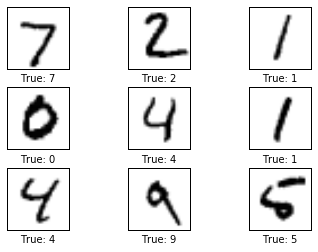

In [9]:
# 绘制辅助函数
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9  # 绘制 9 个图像
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        # 显示标签
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])   # 不显示刻度
        ax.set_yticks([])

images = data.test.images[0:9]
cls_true = data.test.cls[0:9]   # data.test.labels 是 one-hot 的，data.test.cls 是上面转成1维的结果
plot_images(images=images, cls_true=cls_true)

##### Part II. Tensorflow Graph Design

In [10]:
# 定义常量
x = tf.placeholder(tf.float32, [None, img_size_flat])  # None 表示 x 可以表示任意多个 images；images 数据的维度为 img_size_flat；共计 N * 784 维
y_true = tf.placeholder(tf.float32, [None, num_classes]) # 类似上面，y_true 每个标签维度为 num_classes(10)，也即 one-hot ，共计 N * 10 维
y_true_cls = tf.placeholder(tf.int64, [None])  # 任意多个 int64 scalar，也就是 1 维标签结果

In [11]:
# 定义变量
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))   # 784 * 10 维矩阵，初始化为 0
biases = tf.Variable(tf.zeros([num_classes]))   # 10 维矢量，初始化为 0

In [12]:
# 选择 softmax 为输出层
logits = tf.matmul(x, weights) + biases    # (N * 784 矩阵) * (784 * 10 矩阵) + (10 矢量) ===> (N * 10 矩阵) 
y_pred = tf.nn.softmax(logits)    # softmax 为输出，得到 N * 10 维结果
y_pred_cls = tf.argmax(y_pred, dimension=1)    # 取最大的标签 index 为 N * 1 维结果; argmax 在第二个维度上进行，即保持 N 不变，每个 N 中的元素进行 argmax

In [13]:
# 选择 交叉熵 为 lost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)  # softmax_cross_entropy_with_logits also calculates the softmax internally.
cost = tf.reduce_mean(cross_entropy)  # 转化为 1 维，以便比较 lost (cost)，故此取平均值

In [14]:
# 选择 Gradient Descent 为优化函数
# 还可以选择 AdagradOptimizer or AdamOptimizer. 等
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [15]:
# Performance Measures 选择正确分类的比例，即正确分类 / 总数
correct_prediction = tf.equal(y_pred_cls, y_true_cls)  # 每个元素是一个 Bool 值,表示是否 match
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))  # Bool 转为 float 然后取平均值

##### Part III. 真正运行前的准备工作

In [18]:
session = tf.Session()

In [19]:
session.run(tf.initialize_all_variables())

In [20]:
# 使用 Stochastic Gradient Descent , 分 batch 更新
batch_size = 100

def optimize(num_iterations):
    for i in range(num_iterations):
        x_batch, y_true_batch = data.train.next_batch(batch_size)    # 每次迭代只取一个 batch，而不是把所有 training_data 按 batch 都执行一遍
        feed_dict_train = {x: x_batch, y_true: y_true_batch}         # 在这里并没有 feed y_true_cls；这是因为 y_true_cls 只是用于训练之后计算 accuracy，而在训练中没有作用
        session.run(optimizer, feed_dict=feed_dict_train)

In [36]:
# 实现一些用于展示效果的 Helper functions
feed_dict_test = {x: data.test.images, y_true: data.test.labels, y_true_cls: data.test.cls}   # 这里 feed 了 y_true_cls，这是因为 test_data 中的 y_true_cls 需要参与 accuracy 的计算

# 展示 accuracy，即测试集上的正确率
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc)) 
    
# 展示 confusion matrix
def print_confusion_matrix():
    cls_true = data.test.cls
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)   # 刻度为分类的 id
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

# 展示分类错误的图片    
def plot_example_errors():
    correct, cls_pred = session.run([correct_prediction, y_pred_cls], feed_dict=feed_dict_test)    # 取出全部 testdata 分类是否正确以及分类结果
    incorrect = (correct == False)  # 转换为：分类错误则为 True，正确反而为 False
    images = data.test.images[incorrect]  # 过滤出错误图片
    cls_pred = cls_pred[incorrect]  # 过滤出错误结果
    cls_true = data.test.cls[incorrect]   # 过滤出正确结果
    plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9])
    
# 展示 weight
def plot_weights():
    w = session.run(weights)   # 简单的取出训练后得到的 weight，weight 是个 variable，维度为 784 * 10，就是说每个列变量 784 维表示对应分类的权重
    w_min = np.min(w)    # 取出全部 784*10 中最小的
    w_max = np.max(w)    # 取出最大的，目的是为了找到上下界，便于比较不同分类对应的权重
    
    fig, axes = plt.subplots(3, 4)   # 10 个分类的权重，小于 12
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        if i < 10:
            image = w[:, i].reshape(img_shape)    # 784 ==> 28 * 28
            ax.set_xlabel("Weight: {0}".format(i))
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])


##### Part IV. Tensorflow Run Run Run

In [23]:
# 现在刚刚初始化的数据基础上，先不调用 optimize 的情况下，直接计算 accuracy；由于 w & b 都是 0，故此预测值都应该是 0，正确率应该在 1/10 附近
print_accuracy()

Accuracy on test-set: 9.8%


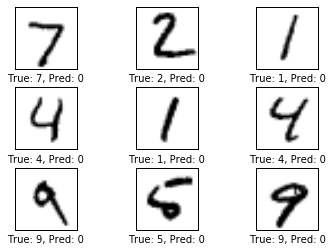

In [28]:
plot_example_errors()    # 应该看到，预测都是 0

In [32]:
optimize(num_iterations=1)  # 进行一次训练，看看结果如何
print_accuracy()

Accuracy on test-set: 40.3%


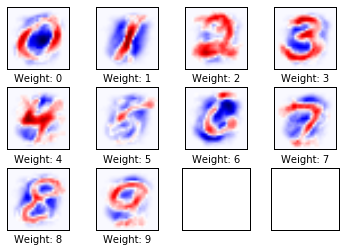

In [37]:
# 看看此时的 weight 图像；红色为 positive, 蓝色为 negative；
# 由于 weight 和 x 同维度，故此红色部分应该和图像中的数字越重合越好；蓝色部分越深，表示那个区域越不应该有笔迹
# 由于训练的图片很少，故此 weight 很清晰，相当于对这一个迭代的 batch 图片做了 overfitting
plot_weights()

In [40]:
# 1000 次迭代的话，如何？
optimize(num_iterations=999)   # 已经迭代过一次了

In [41]:
print_accuracy()

Accuracy on test-set: 91.7%


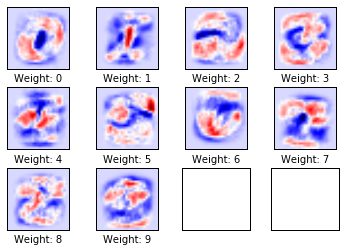

In [42]:
# 由于训练了更多的图片，那么就要考虑去权衡各种图片，于是分类的边界反而变得更模糊不可认，同时减少了 overfitting
plot_weights()

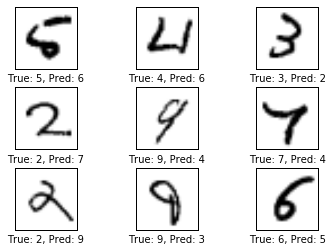

In [43]:
# 有一些结果还是比较 weird 的，比如第二幅，第三幅之类的
plot_example_errors()

[[ 967    0    1    2    0    3    4    2    1    0]
 [   0 1113    2    2    0    1    4    2   11    0]
 [  12   10  902   22    9    3   15   14   41    4]
 [   4    0   18  936    0   17    1   13   18    3]
 [   1    3    2    3  922    1   15    2   10   23]
 [  11    4    3   53    9  759   11    6   32    4]
 [  16    3    2    2   10   15  905    2    3    0]
 [   3   10   23    9    8    0    0  955    2   18]
 [  10   13    4   34    9   30    9   11  854    0]
 [  12    9    1   11   53   12    0   46    7  858]]


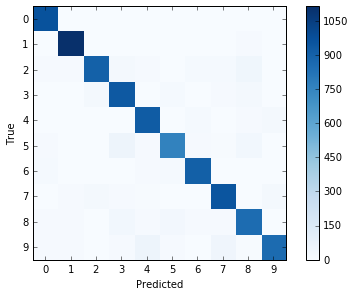

In [44]:
# 打印 confusion matrix ，看到 1 最好认，5最难认；5 很容易被认作 3、8，等等
print_confusion_matrix()